In [1]:
import detection as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast

import EddyDetectionV2 as eddy

# Set default font size to match LaTeX document
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

In [2]:
# Enable/disable computation of different domains
config_parent_domain = True
config_child_domain = True

In [3]:
# Import data #######################################################################################################################
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')

df_OW = df['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = df['Eta']

od = ospy.OceanDataset(df)
od = od.compute.horizontal_velocity_magnitude()

df_hor_vel = od['hor_vel']
# Delete no longer used variables which uses memory
del od, df

# Inner domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)

Computing magnitude of horizontal velocity


In [4]:
# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-06-01T00:00:00.000000000','2018-06-06T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(70,75)).sel(X=slice(-22,2)).sel(time=slice(time[0],time[1]))
FWC = FWC.resample(time='D').mean(dim='time')

eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)

# Eddy center points (Child domain)

In [5]:
# Computes or loads eddy centerpoints
run = config_child_domain

if run:
    eddyLocation = []
    T = len(eta)
    pbar = tqdm(total=T, desc="Running eddy centerpoint algorythm")
    for i in range(len(eta)):
        eddyLocation.append(eddy.eddyDetection(eta_center[i],OW_center[i]))
        pbar.update(1)
    pbar.close()
    with open("eddyCenterpoints_test_v2.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test_v2.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

Running eddy centerpoint algorythm: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


# Testing threshold parameters in Full_eddy_detection

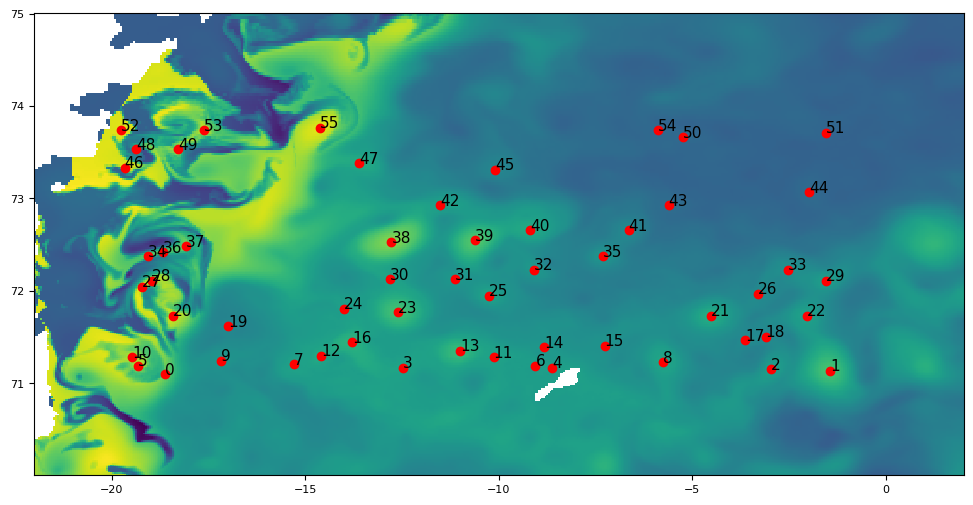

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
for i, data in enumerate(eddyLocation[0][0]):
    ax.scatter(data[1],data[0],c='r')
    ax.annotate(i,xy=[data[1],data[0]])
ax.pcolormesh(eta.X,eta.Y,eta[0],zorder=0)

In [7]:
# # EXP 1: min_vel_diff threshold warm eddy
# eddies = xr.full_like(eta,fill_value=0)
# eddies = eddies.rename("EddyDetection")
# time_ = np.arange(len(eddies.time.values))
# data_EXP1_warm = [eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[time][0],eta=eta[time],hor_vel=hor_vel[time],warm=True,cold=False,test_calib=False,eddiesData=eddies[time],
#                                      min_vel_diff=0.15,
#                                      percentage_diff_vel=55) for time in tqdm(time_,desc='Warm eddy')]
# data_EXP1_cold = [eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[time][1],eta=eta[time],hor_vel=hor_vel[time],warm=False,cold=True,test_calib=False,eddiesData=eddies[time],
#                                      min_vel_diff=0.15,
#                                      percentage_diff_vel=55) for time in tqdm(time_,desc='Cold eddy')]

In [8]:
# for i,j in enumerate(data_EXP1_cold):
#     eddies[i] = j

In [9]:
# eddies = eddies.where(eddies != 0, other=np.nan)
# for time in range(len(eddies)):
#     fig, ax = plt.subplots(figsize=(12,6))
#     # Define the custom colormap
#     colors = ['red', 'blue', 'yellow', 'green']
#     cmap = mcolors.ListedColormap(colors)

#     # Define the normalization
#     bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
#     norm = mcolors.BoundaryNorm(bounds, cmap.N)

#     ax.pcolormesh(eddies.X,eddies.Y,eddies[time],cmap=cmap,alpha=0.3,zorder=1)
#     # ax.set_xlim(eddyLocation[0][0][38][1]-1.5,eddyLocation[0][0][38][1]+3.5)
#     # ax.set_ylim(eddyLocation[0][0][38][0]-1,eddyLocation[0][0][38][0]+1)

#     for i, data in enumerate(eddyLocation[time][0]):
#         ax.scatter(data[1],data[0],c='r',s=3)
#         ax.annotate(i,xy=[data[1],data[0]],fontsize=8)
#     for i, data in enumerate(eddyLocation[time][1]):
#         ax.scatter(data[1],data[0],c='b',s=3)
#         ax.annotate(i,xy=[data[1],data[0]],fontsize=8)

#     mesh = ax.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='YlGnBu',vmin=0,vmax=2,zorder=0)
#     cbar = fig.colorbar(mesh,extend='max')
#     cbar.set_label('FWC [m]')

# Set  up  different experiments for threshold configurations

In [15]:
diff_percentage = [55,57.5,60,65,70,75]
eddies = xr.full_like(eta,fill_value=0)
eddies = eddies.rename("EddyDetection")
time_ = np.arange(len(eddies.time.values))
for time in tqdm(time_,desc='Eddy region detection algorythm'):
    eddies[time] = eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[0][0],eta=eta[0],hor_vel=hor_vel[0],warm=True,cold=False,test_calib=False,eddiesData=eddies[time],
                                     min_vel_diff=0.1,
                                     percentage_diff_vel=diff_percentage[time])
    eddies[time] = eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[0][1],eta=eta[0],hor_vel=hor_vel[0],warm=False,cold=True,test_calib=False,eddiesData=eddies[time],
                                     min_vel_diff=0.1,
                                     percentage_diff_vel=diff_percentage[time])

EXP1 = eddies

Eddy region detection algorythm: 100%|██████████| 6/6 [27:16<00:00, 272.80s/it]


In [1]:
eddies = EXP1
eddies = eddies.where(eddies != 0, other=np.nan)
diff_percentage = [55,57.5,60,65,70,75]

fig, ax = plt.subplots(6,1,figsize=(12,16),sharex=True,layout='constrained')
for time in range(len(eddies)):
    
    ax[time].set_title(f'EXP percentage_diff_vel: {diff_percentage[time]}%')
    # Define the custom colormap
    colors = ['red', 'blue', 'yellow', 'green']
    cmap = mcolors.ListedColormap(colors)

    # Define the normalization
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    ax[time].pcolormesh(eddies.X,eddies.Y,eddies[time],cmap=cmap,alpha=0.3,zorder=1)
    # ax.set_xlim(eddyLocation[0][0][38][1]-1.5,eddyLocation[0][0][38][1]+3.5)
    # ax.set_ylim(eddyLocation[0][0][38][0]-1,eddyLocation[0][0][38][0]+1)

    for i, data in enumerate(eddyLocation[0][0]):
        ax[time].scatter(data[1],data[0],c='r',s=3)
        ax[time].annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[0][1]):
        ax[time].scatter(data[1],data[0],c='b',s=3)
        ax[time].annotate(i,xy=[data[1],data[0]],fontsize=5)
    
    ax[time].set_ylim(71,74)

    mesh = ax[time].pcolormesh(FWC.X,FWC.Y,FWC[0],cmap='YlGnBu',vmin=0,vmax=2,zorder=0)
    cbar = fig.colorbar(mesh,extend='max')
    cbar.set_label('FWC [m]')

    ax[time].contour(hor_vel.X,hor_vel.Y,hor_vel[0],levels=[0.05,0.1,0.15,0.2,0.4,0.6,0.8,1,1.2],colors='grey',linewidths=[0.05,0.1,0.15,0.2,0.4,0.6,0.8,1,1.2])
    vel = hor_vel[0].where(hor_vel > 0.15)
    ax[time].contourf(vel.X,vel.Y,vel,colors='yellow')

NameError: name 'EXP1' is not defined

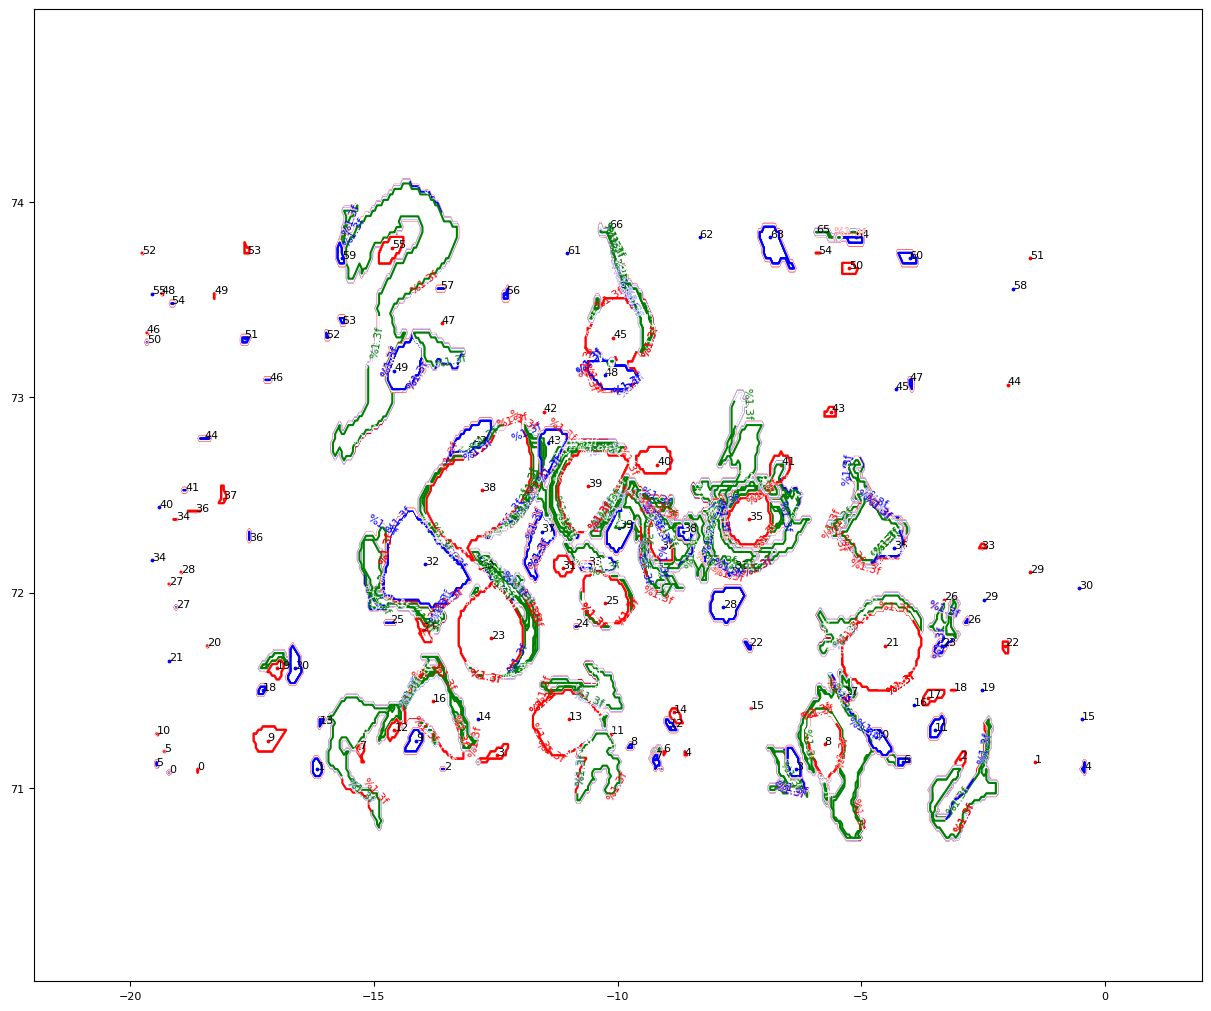

In [12]:
eddies = eddies.where(eddies != 0, other=np.nan)
eddies = eddies.fillna(0)
fig, ax = plt.subplots(figsize=(12,10),layout='constrained')
levels = [0.8,0.9, 1.1, 1.9, 2.1, 3.9, 4.1]
colors = ['white', 'red', 'white', 'blue', 'white', 'green']
for time in range(len(eddies)):
    eddies_ = np.ma.masked_invalid(eddies[time])
    cntr = ax.contour(eddies.X,eddies.Y,eddies_,levels=levels,colors=colors)
    labels = {1: f'{diff_percentage[time]}', 2: f'{diff_percentage[time]}', 4: f'{diff_percentage[time]}'}
    ax.clabel(cntr, fmt=labels, inline=True, fontsize=8)

for i, data in enumerate(eddyLocation[0][0]):
    ax.scatter(data[1],data[0],c='r',s=3)
    ax.annotate(i,xy=[data[1],data[0]],fontsize=8)
for i, data in enumerate(eddyLocation[0][1]):
    ax.scatter(data[1],data[0],c='b',s=3)
    ax.annotate(i,xy=[data[1],data[0]],fontsize=8)

In [17]:
# EXP minimum vel diff
diff_percentage = [0.025,0.05,0.1,0.15,0.2,0.25]
eddies = xr.full_like(eta,fill_value=0)
eddies = eddies.rename("EddyDetection")
time_ = np.arange(len(eddies.time.values))
for time in tqdm(time_,desc='Eddy region detection algorythm'):
    eddies[time] = eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[0][0],eta=eta[0],hor_vel=hor_vel[0],warm=True,cold=False,test_calib=False,eddiesData=eddies[time],
                                     min_vel_diff=diff_percentage[time],
                                     percentage_diff_vel=75)
    eddies[time] = eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[0][1],eta=eta[0],hor_vel=hor_vel[0],warm=False,cold=True,test_calib=False,eddiesData=eddies[time],
                                     min_vel_diff=diff_percentage[time],
                                     percentage_diff_vel=75)
EXP2 = eddies

Eddy region detection algorythm: 100%|██████████| 6/6 [20:59<00:00, 209.93s/it]


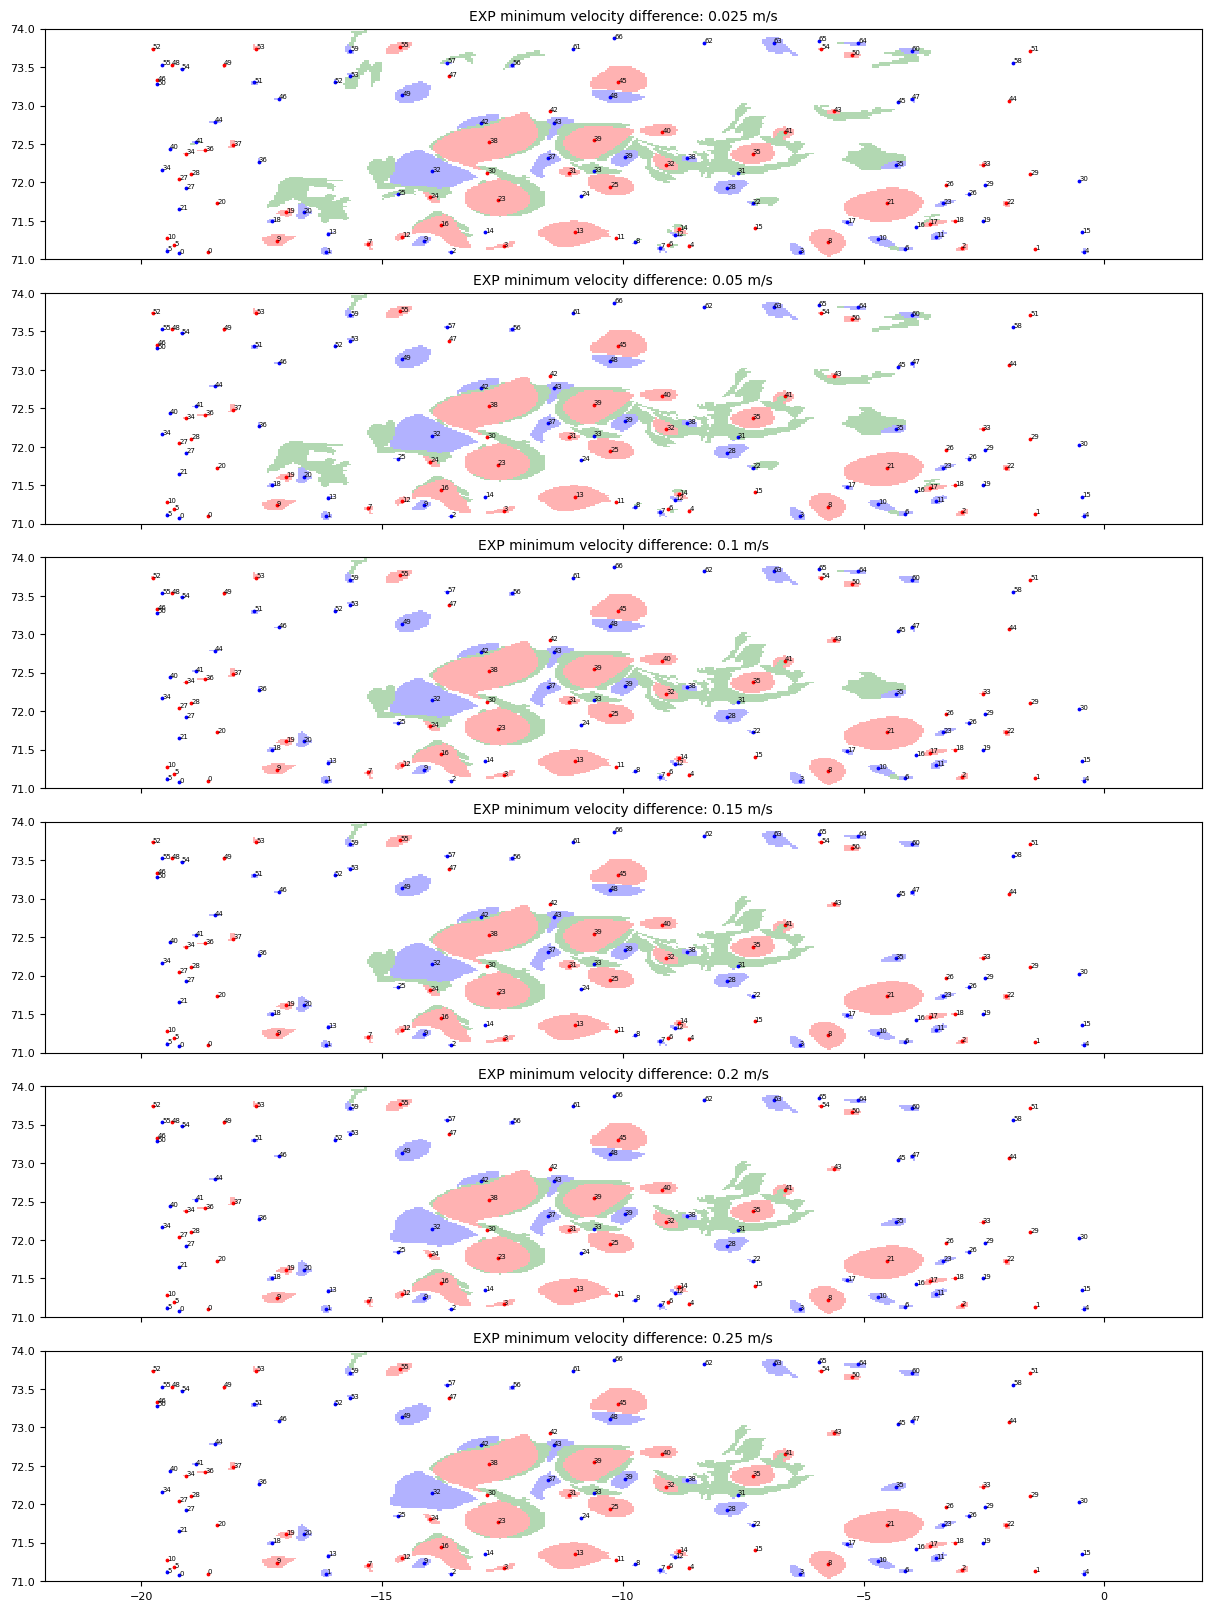

In [18]:
eddies = EXP2
eddies = eddies.where(eddies != 0, other=np.nan)
fig, ax = plt.subplots(6,1,figsize=(12,16),sharex=True,layout='constrained')
for time in range(len(eddies)):
    
    ax[time].set_title(f'EXP minimum velocity difference: {diff_percentage[time]} m/s')
    # Define the custom colormap
    colors = ['red', 'blue', 'yellow', 'green']
    cmap = mcolors.ListedColormap(colors)

    # Define the normalization
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    ax[time].pcolormesh(eddies.X,eddies.Y,eddies[time],cmap=cmap,alpha=0.3,zorder=1)
    # ax.set_xlim(eddyLocation[0][0][38][1]-1.5,eddyLocation[0][0][38][1]+3.5)
    # ax.set_ylim(eddyLocation[0][0][38][0]-1,eddyLocation[0][0][38][0]+1)

    for i, data in enumerate(eddyLocation[0][0]):
        ax[time].scatter(data[1],data[0],c='r',s=3)
        ax[time].annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[0][1]):
        ax[time].scatter(data[1],data[0],c='b',s=3)
        ax[time].annotate(i,xy=[data[1],data[0]],fontsize=5)
    
    ax[time].set_ylim(71,74)

    # mesh = ax.pcolormesh(FWC.X,FWC.Y,FWC[0],cmap='YlGnBu',vmin=0,vmax=2,zorder=0)
    # cbar = fig.colorbar(mesh,extend='max')
    # cbar.set_label('FWC [m]')